# **Project Machine Learning for NLP**

This is the project built by Simon Demouchy and Quentin Deltour for the class ML for NLP. 

We studied the classification of short job position titles onto categories created by Pole Emploi.

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from keras.utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline

## Data 

We load the dataset from the repository on Github.

In [2]:
url_m = 'https://raw.githubusercontent.com/simondemouchy/NLP_Project/main/metiers.csv'
df = pd.read_csv(url_m)

## Data Exploraiton

The following columns are present in the dataset.

In [ ]:
print(df.columns)
print('')
print(df.shape)

Index(['code_grand_domaine', 'appelation_grand_domaine', 'code_domaine',
       'appelation_domaine', 'code_fiche_rome', 'appelation_fiche_rome',
       'code_ogr', 'appelation_metier'],
      dtype='object')

(11109, 8)


The dataset contains 11109 observations. Let's observe some examples of observations.

In [ ]:
print("Nombre de métiers:",df.shape[0])
df.sample(n=5).drop(columns=['code_domaine','code_fiche_rome','code_ogr'])

Nombre de métiers: 11109


,code_grand_domaine,appelation_grand_domaine,appelation_domaine,appelation_fiche_rome,appelation_metier
5159,H,Industrie,Cuir et textile,Conduite de machine de fabrication de produits...,Conducteur / Conductrice de machines de fabric...
7363,J,Santé,Praticiens médico-techniques,Pharmacie,Pharmacien / Pharmacienne
1680,D,"Commerce, Vente et Grande distribution",Force de vente,Relation commerciale grands comptes et entrepr...,Conseiller commercial / Conseillère commercial...
9216,L,Spectacle,Artistes - interprètes du spectacle,Art dramatique,Figurant / Figurante
3507,G,"Hôtellerie-Restauration, Tourisme, Loisirs et ...",Animation d'activités de loisirs,Éducation en activités sportives,Moniteur / Monitrice de fitness musculation


We see that each row corresponds to a single job, and at every job is associated a "fiche rome", then a "domaine" and finally a "grand domaine". 

We can observe what are the attributes of the column "grand domaine".

In [ ]:
df['appelation_grand_domaine'].value_counts()

Industrie                                                                     2685
Services à la personne et à la collectivité                                   1554
Support à l'entreprise                                                         937
Construction, Bâtiment et Travaux publics                                      787
Installation et Maintenance                                                    710
Commerce, Vente et Grande distribution                                         665
Transport et Logistique                                                        606
Communication, Média et Multimédia                                             601
Agriculture et Pêche, Espaces naturels et Espaces verts, Soins aux animaux     589
Hôtellerie-Restauration, Tourisme, Loisirs et Animation                        546
Spectacle                                                                      463
Banque, Assurance, Immobilier                                                  363
Arts

There are 14 "grand domaines". These 14 "grand domaines" are supposed to cover the entire scope of possible jobs in our society.

Inside every "grand domaine", we can find several "domaine", for instance, let's see what are the "domaine" related to the "grand domaine" "Industrie" and "Santé".

In [ ]:
df[df['appelation_grand_domaine'] == 'Industrie']['appelation_domaine'].value_counts()

Mécanique, travail des métaux et outillage                                       480
Conception, recherche, études et développement                                   374
Cuir et textile                                                                  333
Bois                                                                             241
Qualité et analyses industrielles                                                229
Direction, encadrement et pilotage de fabrication et production industrielles    183
Méthodes et gestion industrielles                                                129
Traitements thermiques et traitements de surfaces                                110
Electronique et électricité                                                       92
Hygiène Sécurité Environnement -HSE- industriels                                  84
Plastique, caoutchouc                                                             79
Préparation et conditionnement                                   

In [ ]:
df[df['appelation_grand_domaine'] == 'Santé']['appelation_domaine'].value_counts()

Rééducation et appareillage         66
Soins paramédicaux                  65
Praticiens médicaux                 63
Professionnels médico-techniques    48
Praticiens médico-techniques        14
Name: appelation_domaine, dtype: int64

In [ ]:
print("There are {} grands domaines.".format(df['appelation_grand_domaine'].nunique()))
print("There are {} domaines.".format(df['appelation_domaine'].nunique()))
print("There are {} domaines ROME.".format(df['appelation_fiche_rome'].nunique()))
print("There are {} jobs.".format(df['appelation_metier'].nunique()))

There are 14 grands domaines.
There are 110 domaines.
There are 532 domaines ROME.
There are 11109 jobs.


Also, we have noticed, that when we duplicate the jobs where there are the masculine and the feminine, we get a better score. However, we are not totally sure that this processing is not like cheating, because we artificially almost double the size of the dataset. But we have decided to add this transformation because our goal is to reach the best accuracy atteinable.

In [3]:
def get_masculin(text):
  L = text.split(' ')
  if '/' in L:
    i = L.index('/')
    del L[i:i+2]
    return ' '.join(L)
  else:
    return text

def get_feminin(text):
  L = text.split(' ')
  if '/' in L:
    i = L.index('/')
    del L[i-1:i+1]
    return ' '.join(L)
  else:
    return text

In [4]:
df_m = df.copy()
df_f = df.copy()

df_m['appelation_metier'] = df['appelation_metier'].apply(get_masculin)
df_f['appelation_metier'] = df['appelation_metier'].apply(get_feminin)
neutral_job = list(pd.concat([df_m, df_f])[pd.concat([df_m, df_f]).duplicated(subset=['appelation_metier'])]['appelation_metier'])
df_f = df_f[~df_f['appelation_metier'].isin(neutral_job)]
df = pd.concat([df_m, df_f])
df.shape

(19845, 8)

In [5]:
df['appelation_metier'] = df['appelation_metier'].str.lower()

## **First Baseline Model**

First of all, in order to check the potential of this task, we implement a baseline modes by using a scikit-learn Vectorizer and a Random Forest.

### Grand Domaine

In [ ]:
X = df['appelation_metier'] 
y = OrdinalEncoder().fit_transform(df['code_grand_domaine'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)

In [ ]:
baseline_model = make_pipeline(
        TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
        RandomForestClassifier(),
    )
baseline_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
baseline_model.score(X_test, to_categorical(y_test))

0.6832955404383976

We see that with this straightforward model, we manage to get an accuracy of $69\%$.

This result encourages us to build more complex model in order to increase this score.

### Domaine

In [ ]:
y = OrdinalEncoder().fit_transform(df['code_domaine'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)

In [ ]:
baseline_model_domaine = make_pipeline(
        TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
        RandomForestClassifier(),
    )
baseline_model_domaine.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
baseline_model_domaine.score(X_test, to_categorical(y_test))

0.6067019400352733

### Fiche ROME

In [ ]:
y = OrdinalEncoder().fit_transform(df['code_fiche_rome'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)

In [ ]:
baseline_model_rome = make_pipeline(
        TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1, 2)),
        RandomForestClassifier(),
    )
baseline_model_rome.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
baseline_model_rome.score(X_test, to_categorical(y_test))

0.5313681027966742

## **CBOW Model**

In this section, we implement a Continuous Bag-of-Word.

In [ ]:
X = df['appelation_metier'] 
y = OrdinalEncoder().fit_transform(df['code_grand_domaine'].values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
y_train = to_categorical(y_train)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print('We find %s unique tokens on the training dataset.' % len(word_index))

We find 6116 unique tokens on the training dataset.


In [ ]:
seq_length = [len(s) for s in sequences]
print("Average length: %0.1f" % np.mean(seq_length))
print("Max length: %d" % max(seq_length))

Average length: 4.2
Max length: 16


As expected, the lenght of the job's title is quite short.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = max(seq_length)

#We pad all the sequences in order to have compatible sentences.
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data train tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

Shape of data train tensor: (16868, 16)
Shape of data test tensor: (2977, 16)


In [ ]:
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

EMBEDDING_DIM = 50
N_CLASSES = y_train.shape[1]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

cbow_model = Model(sequence_input, predictions)
cbow_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])

In [ ]:
cbow_model.fit(X_train, y_train, validation_split=0.1,
          epochs=5, batch_size=32)

Epoch 1/5
475/475 [==============================] - 4s 6ms/step - loss: 1.9223 - acc: 0.4141 - val_loss: 0.6067 - val_acc: 0.8370
Epoch 2/5
475/475 [==============================] - 2s 5ms/step - loss: 0.4056 - acc: 0.9052 - val_loss: 0.3896 - val_acc: 0.8761
Epoch 3/5
475/475 [==============================] - 2s 5ms/step - loss: 0.1523 - acc: 0.9692 - val_loss: 0.3300 - val_acc: 0.8915
Epoch 4/5
475/475 [==============================] - 2s 5ms/step - loss: 0.0685 - acc: 0.9862 - val_loss: 0.3105 - val_acc: 0.8998
Epoch 5/5
475/475 [==============================] - 2s 5ms/step - loss: 0.0448 - acc: 0.9895 - val_loss: 0.3382 - val_acc: 0.8992


In [ ]:
y_pred = np.argmax(cbow_model(X_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(y_pred == y_test))

Test accuracy: 0.9005710446758481


Thanks to this model, we obtain an accuracy of $90\%$, which represents an overtaking of the baseline model by twenty points. This is a significant increase.

We can also check the ability of this model to predict the "domain". As it has more different values, we expect the accuracy of the model to drop, but it would be more interesting. 

In [ ]:
domaine = OrdinalEncoder().fit_transform(df['appelation_domaine'].values.reshape(-1,1))
X_train, X_test, domaine_train, domaine_test = train_test_split(X, domaine, test_size=0.15, random_state=42)
domaine_train = to_categorical(domaine_train)

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
EMBEDDING_DIM = 100
N_CLASSES = domaine_train.shape[1]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

cbow_model_domaine = Model(sequence_input, predictions)
cbow_model_domaine.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])
cbow_model_domaine.fit(X_train, domaine_train, validation_split=0.1,
          epochs=5, batch_size=32)

Epoch 1/5
475/475 [==============================] - 4s 7ms/step - loss: 3.7679 - acc: 0.2035 - val_loss: 1.4293 - val_acc: 0.7172
Epoch 2/5
475/475 [==============================] - 3s 7ms/step - loss: 0.9734 - acc: 0.8036 - val_loss: 0.7761 - val_acc: 0.8257
Epoch 3/5
475/475 [==============================] - 3s 7ms/step - loss: 0.3229 - acc: 0.9485 - val_loss: 0.6011 - val_acc: 0.8536
Epoch 4/5
475/475 [==============================] - 3s 7ms/step - loss: 0.1363 - acc: 0.9816 - val_loss: 0.5490 - val_acc: 0.8702
Epoch 5/5
475/475 [==============================] - 3s 7ms/step - loss: 0.0642 - acc: 0.9914 - val_loss: 0.5378 - val_acc: 0.8743


In [ ]:
domaine_pred = np.argmax(cbow_model_domaine(X_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(domaine_pred == domaine_test))

Test accuracy: 0.8646288209606987


As expected the accuracy is lower but still acceptable given the significant rise of the number of classes (from 14 to 110)

Now lets turn to the "Fiche Rome". Here the number of classes increases from 110 to 532. 

Considering the size of our dataset, it might become difficult to get a good score.

In [ ]:
rome = OrdinalEncoder().fit_transform(df['appelation_fiche_rome'].values.reshape(-1,1))
X_train, X_test, rome_train, rome_test = train_test_split(X, rome, test_size=0.15, random_state=42)
rome_train = to_categorical(rome_train)

tokenizer = Tokenizer(char_level=False)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
EMBEDDING_DIM = 100
N_CLASSES = rome_train.shape[1]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

cbow_model_rome = Model(sequence_input, predictions)
cbow_model_rome.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01), metrics=['acc'])
cbow_model_rome.fit(X_train, rome_train, validation_split=0.1,
          epochs=6, batch_size=32)

Epoch 1/6
475/475 [==============================] - 4s 7ms/step - loss: 5.7132 - acc: 0.0586 - val_loss: 3.2386 - val_acc: 0.4280
Epoch 2/6
475/475 [==============================] - 3s 7ms/step - loss: 2.4169 - acc: 0.5560 - val_loss: 1.5870 - val_acc: 0.6823
Epoch 3/6
475/475 [==============================] - 3s 7ms/step - loss: 0.9207 - acc: 0.8365 - val_loss: 1.1069 - val_acc: 0.7736
Epoch 4/6
475/475 [==============================] - 3s 7ms/step - loss: 0.3935 - acc: 0.9449 - val_loss: 0.9002 - val_acc: 0.8168
Epoch 5/6
475/475 [==============================] - 3s 7ms/step - loss: 0.1787 - acc: 0.9863 - val_loss: 0.8168 - val_acc: 0.8340
Epoch 6/6
475/475 [==============================] - 3s 7ms/step - loss: 0.0807 - acc: 0.9957 - val_loss: 0.7974 - val_acc: 0.8340


In [ ]:
rome_pred = np.argmax(cbow_model_rome(X_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(rome_pred == rome_test))

Test accuracy: 0.8374202216996977


We could make the same remark than for "domaine" : the accuracy dropped due to the high increase in the number of classes.

## **Transformer**

In [ ]:
%pip install -q transformers==2.11.0
%pip install sentencepiece
%pip install fairseq

In [7]:
import fairseq

In this section, we need to split the dataset into three datasets.

In [8]:
X = df['appelation_metier']
y = OrdinalEncoder().fit_transform(df['code_grand_domaine'].values.reshape(-1,1))

X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from transformers import CamembertTokenizer

model_name = "camembert-base"
camembert_tokenizer = CamembertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


Let's inspect the tokens created by CamemBert.

In [ ]:
print(df['appelation_metier'].iloc[0])
print(camembert_tokenizer.tokenize(df['appelation_metier'].iloc[0]))

chauffeur de machines agricoles
['▁chauffeur', '▁de', '▁machines', '▁agricoles']


Average length: 8.2
Max length: 29


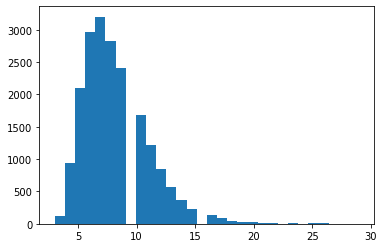

In [10]:
train_sequence_lengths = [len(camembert_tokenizer.encode(job))
                          for job in df['appelation_metier']]
print("Average length: %0.1f" % np.mean(train_sequence_lengths))
print("Max length: %d" % max(train_sequence_lengths))
plt.hist(train_sequence_lengths, bins=30)
plt.show()

The sequences are longer than the ones in the CBOW model.

In [11]:
def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

In [12]:
encoded_train = encode_dataset(camembert_tokenizer, X_train, 35)
encoded_valid = encode_dataset(camembert_tokenizer, X_valid, 35)
encoded_test = encode_dataset(camembert_tokenizer, X_test, 35)

In [13]:
import tensorflow as tf
from keras.layers import Dropout, Dense
from transformers import TFCamembertModel

class JobClassificationModel(tf.keras.Model):

    def __init__(self, num_labels=None, model_name="jplu/tf-camembert-base",
                 dropout_prob=0.1):
        super().__init__(name="job_class")
        self.camembert = TFCamembertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.job_classifier = Dense(num_labels)

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.camembert(inputs, **kwargs)

        pooled_output = self.dropout(pooled_output,
                                     training=kwargs.get("training", False))
        
        job_logits = self.job_classifier(pooled_output)
        return job_logits

camembert_model = JobClassificationModel(num_labels=14)

In [14]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

camembert_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=CategoricalCrossentropy(from_logits=True),
                     metrics=[CategoricalAccuracy('accuracy')])

In [17]:
tf.config.run_functions_eagerly(True)
history = camembert_model.fit(encoded_train, to_categorical(y_train), epochs=4, batch_size=32,
                           validation_data=(encoded_valid, to_categorical(y_valid)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/4
422/422 [==============================] - 169s 401ms/step - loss: 0.5163 - accuracy: 0.8572 - val_loss: 0.5068 - val_accuracy: 0.8604
Epoch 2/4
422/422 [==============================] - 170s 402ms/step - loss: 0.3476 - accuracy: 0.9038 - val_loss: 0.4433 - val_accuracy: 0.8856
Epoch 3/4
422/422 [==============================] - 170s 403ms/step - loss: 0.2575 - accuracy: 0.9279 - val_loss: 0.3993 - val_accuracy: 0.8897
Epoch 4/4
422/422 [==============================] - 172s 407ms/step - loss: 0.1958 - accuracy: 0.9444 - val_loss: 0.3785 - val_accuracy: 0.9081


In [18]:
y_pred = np.argmax(camembert_model(encoded_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(y_pred == y_test))

Test accuracy: 0.9129996640913671


We get an accuracy a little bit higher than in the CBOW model.

Domaine

In [19]:
X = df['appelation_metier'] 
domaine = OrdinalEncoder().fit_transform(df['appelation_domaine'].values.reshape(-1,1))

X, X_test, domaine, domaine_test = train_test_split(X, domaine, test_size=0.15, random_state=42)
X_train, X_valid, domaine_train, domaine_valid = train_test_split(X, domaine, test_size=0.2, random_state=42)

encoded_train = encode_dataset(camembert_tokenizer, X_train, 35)
encoded_valid = encode_dataset(camembert_tokenizer, X_valid, 35)
encoded_test = encode_dataset(camembert_tokenizer, X_test, 35)

In [20]:
camembert_model_domaine = JobClassificationModel(num_labels=110)

In [21]:
camembert_model_domaine.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=CategoricalCrossentropy(from_logits=True),
                     metrics=[CategoricalAccuracy('accuracy')])

In [22]:
tf.config.run_functions_eagerly(True)
history = camembert_model_domaine.fit(encoded_train, to_categorical(domaine_train), epochs=4, batch_size=32,
                           validation_data=(encoded_valid, to_categorical(domaine_valid)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/4
422/422 [==============================] - 172s 406ms/step - loss: 4.3136 - accuracy: 0.0983 - val_loss: 2.7208 - val_accuracy: 0.4576
Epoch 2/4
422/422 [==============================] - 171s 405ms/step - loss: 2.4725 - accuracy: 0.4994 - val_loss: 1.5643 - val_accuracy: 0.6550
Epoch 3/4
422/422 [==============================] - 171s 406ms/step - loss: 1.3951 - accuracy: 0.7034 - val_loss: 1.0416 - val_accuracy: 0.7715
Epoch 4/4
422/422 [==============================] - 169s 401ms/step - loss: 0.8265 - accuracy: 0.8335 - val_loss: 0.7369 - val_accuracy: 0.8352


In [24]:
domaine_pred = np.argmax(camembert_model_domaine(encoded_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(domaine_pred == domaine_test))

Test accuracy: 0.831709774941216


Code Rome

In [25]:
X = df['appelation_metier'] 
domaine = OrdinalEncoder().fit_transform(df['appelation_fiche_rome'].values.reshape(-1,1))

X, X_test, rome, rome_test = train_test_split(X, domaine, test_size=0.15, random_state=42)
X_train, X_valid, rome_train, rome_valid = train_test_split(X, rome, test_size=0.2, random_state=42)

encoded_train = encode_dataset(camembert_tokenizer, X_train, 35)
encoded_valid = encode_dataset(camembert_tokenizer, X_valid, 35)
encoded_test = encode_dataset(camembert_tokenizer, X_test, 35)

In [26]:
camembert_model_rome = JobClassificationModel(num_labels=532)

In [27]:
camembert_model_rome.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=CategoricalCrossentropy(from_logits=True),
                     metrics=[CategoricalAccuracy('accuracy')])

In [28]:
tf.config.run_functions_eagerly(True)
history = camembert_model_rome.fit(encoded_train, to_categorical(rome_train), epochs=3, batch_size=32,
                           validation_data=(encoded_valid, to_categorical(rome_valid)))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/3
422/422 [==============================] - 169s 400ms/step - loss: 6.2229 - accuracy: 0.0080 - val_loss: 5.9519 - val_accuracy: 0.0296
Epoch 2/3
422/422 [==============================] - 169s 401ms/step - loss: 5.7720 - accuracy: 0.0643 - val_loss: 5.0357 - val_accuracy: 0.1769
Epoch 3/3
422/422 [==============================] - 169s 401ms/step - loss: 4.8259 - accuracy: 0.2131 - val_loss: 4.0425 - val_accuracy: 0.3112


In [30]:
rome_pred = np.argmax(camembert_model_rome(encoded_test), axis=-1).reshape(-1,1)
print("Test accuracy:", np.mean(rome_pred == rome_test))

Test accuracy: 0.2972791400738999


It seems that the model doesn't work well with so many classes.

## **Fast Text**

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42) 

### Grand Domaine

Now let's create the file that will be used as an input to our Fast Text model for Grand Domaine:

In [ ]:
with open('fasttext_input_train.txt', 'w') as f:
    for each_text, each_label in zip(train['appelation_metier'], train['code_grand_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [ ]:
with open('fasttext_input_vali.txt', 'w') as f:
    for each_text, each_label in zip(valid['appelation_metier'], valid['code_grand_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [ ]:
with open('fasttext_input_test.txt', 'w') as f:
    for each_text, each_label in zip(test['appelation_metier'], test['code_grand_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

We want our model to have the best performances. To do so, we autotune him with a specified duration (lets say 20 minutes, 1200 seconds)

In [ ]:
#fasttext_model = fasttext.train_supervised('fasttext_input_train.txt', autotuneValidationFile='fasttext_input_vali.txt', autotuneDuration=1200)

Let's have a look at the hyperparameters chosen:

In [ ]:
#args_obj = fasttext_model.f.getArgs()
#for hparam in dir(args_obj):
#    if not hparam.startswith('__'):
#        print(f"{hparam} -> {getattr(args_obj, hparam)}")

We are especially interested in : 
- minn and maxn : number of character ngram taken onto account : 
- wordNgram : the maximum number of word ngram taken onto account 

We do not need to autotune each time. Once we know the best hyper parameters, we can directly train a model with these hyperparameters. 

In [ ]:
fasttext_model = fasttext.train_supervised('fasttext_input_train.txt', epoch=100, maxn=5, minn=2, wordNgrams=5)

In [ ]:
print("The accuracy on the {} elements belonging to the test set is: {}".format(*fasttext_model.test('fasttext_input_test.txt')))

The accuracy on the 2977 elements belonging to the test set is: 0.9197178367484045


We could also look, by hand, at the categories predicted for a name of job. Here for example, the top 3 proposition of the model for the job "Médecin" are:
- J (Health) with a probability of 0.98
- L (Spectale) with a probability of 0.01
- A (Agriculture) with a probability < 0.01

This is indeed the good prediction.

In [ ]:
fasttext_model.predict("Medecin", k=3)

(('__label__J', '__label__L', '__label__A'),
 array([0.98054701, 0.0113408 , 0.00458748]))

Now we want to plot the confusion matrix in order to better understand where the mistakes have been made. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


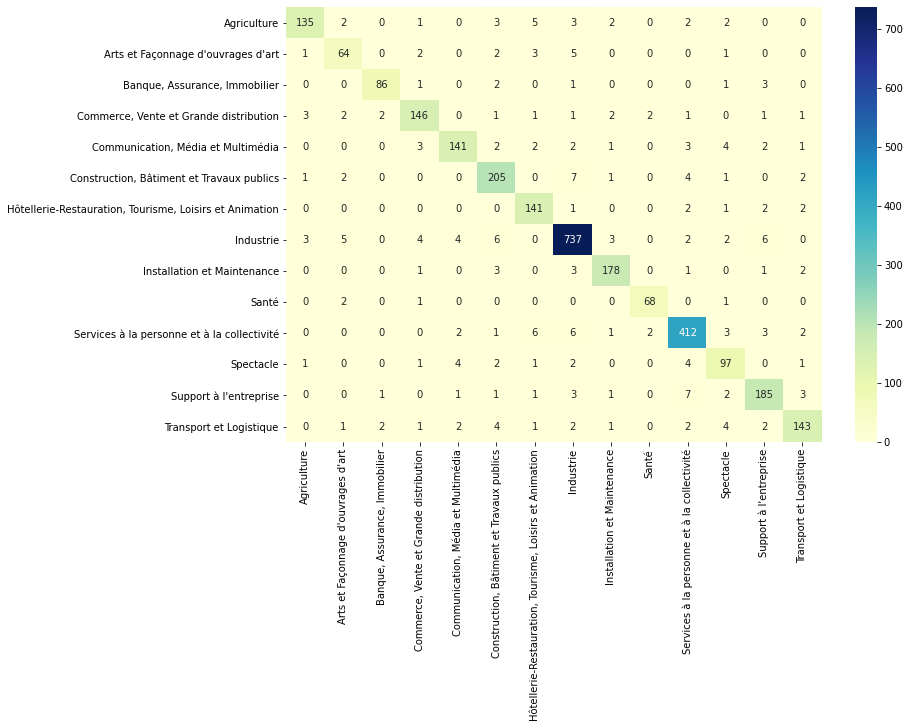

In [ ]:
labels = sorted(test['code_grand_domaine'].unique())
dic_grand_domaine = {code: test[test.code_grand_domaine==code]['appelation_grand_domaine'].iloc[0] for code in labels}

new_labels = [dic_grand_domaine.get(label) for label in labels]
new_labels[0] = 'Agriculture'
test["gd_predicted"] = test["appelation_metier"].apply(lambda x: fasttext_model.predict(x)[0][0])
test['gd_predicted'] = test['gd_predicted'].str.replace('__label__', '')
df_cm = pd.DataFrame(confusion_matrix(test["code_grand_domaine"], test["gd_predicted"]), index=new_labels, columns=new_labels)

plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, fmt='.0f',cmap="YlGnBu")

plt.savefig('confusion_matrix_labels.png', bbox_inches='tight')

### Domaine

In [ ]:
with open('fasttext_input_domaine_train.txt', 'w') as f:
    for each_text, each_label in zip(train['appelation_metier'], train['code_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('fasttext_input_domaine_vali.txt', 'w') as f:
    for each_text, each_label in zip(valid['appelation_metier'], valid['code_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('fasttext_input_domaine_test.txt', 'w') as f:
    for each_text, each_label in zip(test['appelation_metier'], test['code_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [ ]:
fasttext_domaine_model = fasttext.train_supervised('fasttext_input_domaine_train.txt', epoch=100, maxn=5, minn=2, wordNgrams=5)

In [ ]:
print("The accuracy of Domaine on the {} elements belonging to the test set is: {}".format(*fasttext_domaine_model.test('fasttext_input_domaine_test.txt')))

The accuracy of Domaine on the 2977 elements belonging to the test set is: 0.8700033590863285


### Code Rome

In [ ]:
with open('fasttext_input_rome_train.txt', 'w') as f:
    for each_text, each_label in zip(train['appelation_metier'], train['code_fiche_rome']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('fasttext_input_rome_vali.txt', 'w') as f:
    for each_text, each_label in zip(valid['appelation_metier'], valid['code_fiche_rome']):
        f.writelines(f'__label__{each_label} {each_text}\n')

with open('fasttext_input_rome_test.txt', 'w') as f:
    for each_text, each_label in zip(test['appelation_metier'], test['code_fiche_rome']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [ ]:
fasttext_rome_model = fasttext.train_supervised('fasttext_input_rome_train.txt', epoch=100, maxn=5, minn=2, wordNgrams=5)

In [ ]:
print("The accuracy of Code ROME on the {} elements belonging to the test set is: {}".format(*fasttext_rome_model.test('fasttext_input_rome_test.txt')))

The accuracy of Code ROME on the 2977 elements belonging to the test set is: 0.8186093382599933


## **Comparison of results**

We sum-up the results in a dataframe.

In [ ]:
cbow = [89.92, 86.29, 83.7]
camembert = [91, 87, 0.01]
fasttext = [91.97,87,81.86]
pd.DataFrame(np.array([cbow, camembert, fasttext]),index=['CBOW','CamemBert','Fast Text'],
                   columns=['Grand Domaine', 'Domaine', 'Code Rome'], dtype = float)

,Grand Domaine,Domaine,Code Rome
CBOW,89.92,86.29,83.70
CamemBert,91.00,87.00,0.01
Fast Text,91.97,87.00,81.86


We observe that the 3 models achieve similar accuracies.

## **External Validity**

In this section, we want to check the validy of each model with data coming from a different source. This would allow us to establish if our models are able to be generalized to other type of data (for example, surveys). 

We use a dataset of annotated jobs from ONISEP (French public institute of information on education and jobs).It includes a "Code ROME" which allows us to retrieve the Code Grand domaine that we have studied so far.

In [ ]:
url_onisep = "https://raw.githubusercontent.com/simondemouchy/NLP_Project/main/metiers-onisep.csv"

onisep = pd.read_csv(url_onisep, sep=';')
onisep = onisep.drop(columns = ['lien site onisep.fr', 'collection', 'année', 'gencod', 'lien ROME'])
onisep['code_grand_domaine'] = onisep['code ROME'].str[0]
print(onisep.shape)
onisep.head(3)

(1142, 7)


,libellé métier,nom publication,GFE,code ROME,libellé ROME,domaine/sous-domaine ONISEP,code_grand_domaine
0,architecte,"Les métiers de l'architecture, de l'urbanisme ...",C : Bâtiment,F1101,Architecture du BTP et du paysage,construction - architecture - travaux publics/...,F
1,géomètre-topographe,Les métiers de l'immobilier,C : Bâtiment,F1108,Métré de la construction,construction - architecture - travaux publics/...,F
2,technicien / technicienne de maintenance en gé...,Les métiers du bâtiment et des travaux publics,"H : Electricité, énergie, électronique",I1308,Maintenance d'installation de chauffage,construction - architecture - travaux publics/...,I


In [ ]:
onisep_m = onisep.drop(columns=['libellé métier']).copy()
onisep_f = onisep.drop(columns=['libellé métier']).copy()

onisep_m['appelation_metier'] = onisep['libellé métier'].apply(get_masculin)
onisep_f['appelation_metier'] = onisep['libellé métier'].apply(get_feminin)
neutral_job = list(pd.concat([onisep_m, onisep_f])[pd.concat([onisep_m, onisep_f]).duplicated(subset=['appelation_metier'])]['appelation_metier'])
onisep_f = onisep_f[~onisep_f['appelation_metier'].isin(neutral_job)]
onisep = pd.concat([onisep_m, onisep_f])
onisep.shape

(1514, 7)

In [ ]:
onisep.isnull().sum()

nom publication                269
GFE                              0
code ROME                      110
libellé ROME                   110
domaine/sous-domaine ONISEP      0
code_grand_domaine             110
appelation_metier                0
dtype: int64

There are NaNs in this dataframe, we must handle them before going on. The columns that matter are "appelation_metier", "code ROME", and "code_grand_domaine".

In [ ]:
onisep = onisep.dropna(subset=['code_grand_domaine'])
onisep.shape

(1404, 7)

In [ ]:
onisep = onisep.drop_duplicates(subset=['appelation_metier'])
onisep.shape

(1055, 7)

Finally, we delete the duplicate jobs and the jobs which were also present in the first dataset.

In [ ]:
jobs_poleemploi = df['appelation_metier'].unique()
onisep = onisep[~onisep['appelation_metier'].isin(jobs_poleemploi)]
onisep = onisep.reset_index()
onisep.shape

(610, 8)

CBOW

In [ ]:
sequences_onisep = tokenizer.texts_to_sequences(onisep['appelation_metier'])
X_onisep = pad_sequences(sequences_onisep, maxlen=MAX_SEQUENCE_LENGTH)
y_pred = np.argmax(cbow_model(X_onisep), axis=-1).reshape(-1,1)
print('Accuracy with CBOW model: ', np.mean(y_pred == OrdinalEncoder().fit_transform(onisep['code_grand_domaine'].values.reshape(-1,1))))

Accuracy with CBOW model:  0.7311475409836066


Transformer

In [ ]:
encoded_test = encode_dataset(camembert_tokenizer, onisep['appelation_metier'], 35)
y_pred = np.argmax(camembert_model(encoded_test), axis=-1).reshape(-1,1)
print("Accuracy with CamemBert model:", np.mean(y_pred == OrdinalEncoder().fit_transform(onisep['code_grand_domaine'].values.reshape(-1,1))))

Accuracy with CamemBert model: 0.7950819672131147


Fast text

In [ ]:
with open('onisep_test.txt', 'w') as f:
    for each_text, each_label in zip(onisep['appelation_metier'], onisep['code_grand_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')

print('Accuracy with Fast Text model:', fasttext_model.test('onisep_test.txt')[1])

Accuracy with Fast Text model: 0.7032786885245902


## **Performance with spelling mistake**

Also, in real life problem, jobs can be written with spelling mistakes. Therefore, we can look at the evolution of the accuracy according the rate of jobs with spelling mistakes.

In [ ]:
def delete_random_letter(text):
  L = list(text)
  n = len(L)
  i  = np.random.randint(0,n)
  L.pop(i)
  return ''.join(L)
delete_random_letter('statisticien')

'satisticien'

In [ ]:
acc_cbow = []
acc_transformer = []
acc_fasttext = []
R = [0.2 * i for i in range(6)]
for r in R:
  onisep_mistake = onisep.copy()
  sel = np.random.randint(onisep.shape[0],size=int(r * onisep.shape[0]))
  onisep_mistake.loc[sel,'appelation_metier'] = onisep_mistake.loc[sel,'appelation_metier'].apply(delete_random_letter)

  #CBOW
  sequences_onisep = tokenizer.texts_to_sequences(onisep_mistake['appelation_metier'])
  X_onisep = pad_sequences(sequences_onisep, maxlen=MAX_SEQUENCE_LENGTH)
  y_pred = np.argmax(cbow_model(X_onisep), axis=-1).reshape(-1,1)
  acc_cbow.append(np.mean(y_pred == OrdinalEncoder().fit_transform(onisep_mistake['code_grand_domaine'].values.reshape(-1,1))))

  #Transformer
  encoded_test = encode_dataset(camembert_tokenizer, onisep_mistake['appelation_metier'], 35)
  y_pred = np.argmax(camembert_model(encoded_test), axis=-1).reshape(-1,1)
  acc_transformer.append(np.mean(y_pred == OrdinalEncoder().fit_transform(onisep_mistake['code_grand_domaine'].values.reshape(-1,1))))

  #Fasttext
  with open('onisep_test.txt', 'w') as f:
    for each_text, each_label in zip(onisep_mistake['appelation_metier'], onisep_mistake['code_grand_domaine']):
        f.writelines(f'__label__{each_label} {each_text}\n')
  acc_fasttext.append(fasttext_model.test('onisep_test.txt')[1])

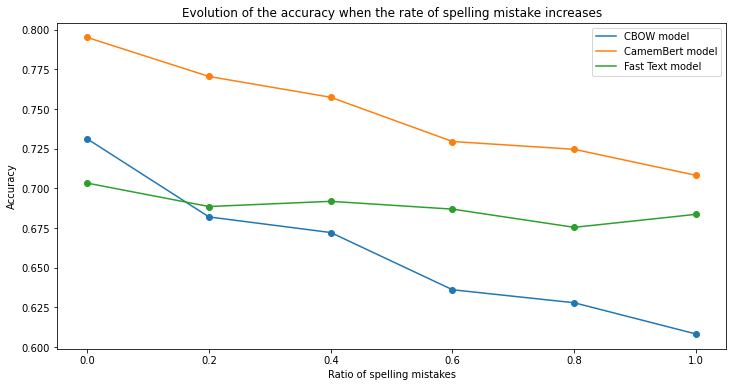

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(R, acc_cbow, label = 'CBOW model' )
plt.scatter(R, acc_cbow)
plt.plot(R, acc_transformer, label = 'CamemBert model' )
plt.scatter(R, acc_transformer)
plt.plot(R, acc_fasttext, label = 'Fast Text model' )
plt.scatter(R, acc_fasttext)
plt.legend(loc='upper right')
plt.title('Evolution of the accuracy when the rate of spelling mistake increases')
plt.ylabel('Accuracy')
plt.xlabel('Ratio of spelling mistakes')

plt.savefig('spelling_mistakes.png')

plt.show()